In [7]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
import pickle


from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import RandomForestClassifier
from warnings import filterwarnings

## Load settings

In [8]:
pd.set_option('display.max_colwidth',-1)
import sys
np.set_printoptions(threshold=sys.maxsize)
filterwarnings('ignore')

k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA
taskname = "task6"
filedir = "/home/fredrik/Documents/Learning_Systems/Labs/Project/"

scoring='accuracy' # Scoring method for GridsearchCV
score_function = f_classif # Score function for Feature selection


np.random.seed(seed) # Define the random seed

In [9]:
# Define models that should be trained
estimators = [
    ('clf', 'passthrough'),
]
param_grid = [
    {
        'clf':[LinearSVC()],
        'clf__penalty':['l1','l2'],
        'clf__C': [0.1,0.5,1,1.5,2.0],
        'clf__dual':[True,False]
    },{
        'clf':[SVC()],
        'clf__C':[1,0.5,1,5.2],
        'clf__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__degree':[1,2,3],
        'clf__gamma':['scale', 'auto'],
        'clf__max_iter':[1000,5000,10000],
    },{
        'clf':[RandomForestClassifier()],
        'clf__n_estimators':[100,150,200],
    },{
        'clf':[KNeighborsClassifier()],
        'clf__n_neighbors':[5,3,6,8],
        'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'clf__leaf_size':[30,15,20,40]
    },{
        'clf':[MLPClassifier()],
        'clf__hidden_layer_sizes':[(100,20)],
        'clf__activation':['relu', 'tanh', 'logistic'],
        'clf__solver':['adam', 'lbfgs'],
        'clf__alpha':[0.0001,0.001,0.1],
        'clf__max_iter':[200,400],
        'clf__early_stopping':[True, False]
    }
]

# Task 6 - Classification 

## Load dataset

In [10]:
filename = "datasets/ECGITtrain.mat"

mat = loadmat(filename)
input_train = mat['inputECGITtrain']

target_train = mat['outputECGITtrain'].reshape(len(input_train))
input_test = mat['inputECGITtest']

## Data info

In [11]:
get_data_info(input_train, target_train)

Length of 200
X.shape: (200, 312) y.shape: (200,)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False
Input: [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.2637258e+00
   9.2601681e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  3.1220163e+00  1.2148618e+00  0.0000000e+00
   0.0000000e+00  6.1585301e+01  6.1909145e+01  1.6335660e+01
   0.0000000e+00  0.0000000e+00  3.5444985e+01  2.8112628e+01
   1.7818724e+01  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.9061192e+01  7.6414699e+01  2.4873216e+01  2.6255317e+01
   4.3691186e+01  6.4112370e+01  1.0255501e+02  8.1948815e+01
   5.8729296e+01  4.6930479e+01  4.2900319e+01  4.1267905e+01
   5.2379063e+01  0.0000000e+00  3.4440635e+01  8.7603284e+01
   7.5542706e+01  6.3913070e+01  0.0000000e+00  1.4891966e+01
   5.2771863e+01  8.7947505e+01  9.3884819e+01  9.6732095e+01
   6.6559745e+01  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000

## Preprocess
Normalize the dataset

In [12]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

200


## Feature reduction
Reduce dimensionality by PCA transform

In [13]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train, input_train_copy)

original shape:    (200, 312)
transformed shape: (200, 68)
Explained variance: [0.13689165 0.10947223 0.08835791 0.05714188 0.03852058 0.03348119
 0.02998714 0.02927492 0.02559136 0.02323128 0.02056029 0.01891973
 0.01810861 0.01627311 0.01578273 0.01518965 0.01288996 0.01232019
 0.01165783 0.01106354 0.01025566 0.01020286 0.00963132 0.00899118
 0.00888426 0.00835079 0.00780978 0.00768602 0.00738474 0.00729493
 0.00691865 0.00648512 0.0063632  0.00611334 0.0060643  0.00559347
 0.00536385 0.00515121 0.00511318 0.00485909 0.00444808 0.00431979
 0.00426217 0.0040189  0.00380549 0.00361753 0.00353812 0.00350734
 0.00327855 0.00316379 0.00309998 0.00306435 0.00289113 0.00285685
 0.00281515 0.00262383 0.00255781 0.00252214 0.00235482 0.00228139
 0.00223909 0.00213703 0.00210408 0.00206141 0.00195353 0.00191249
 0.00182698 0.00179275]


# Plot PCA

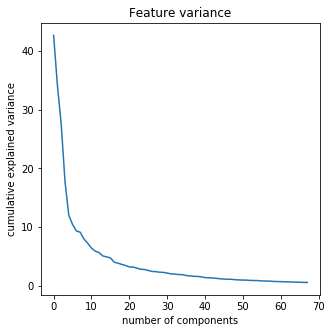

In [14]:
plot_feature_variance(pca_input, filedir=filedir, taskname=taskname)

## Plot top 10 histogram over reduced features

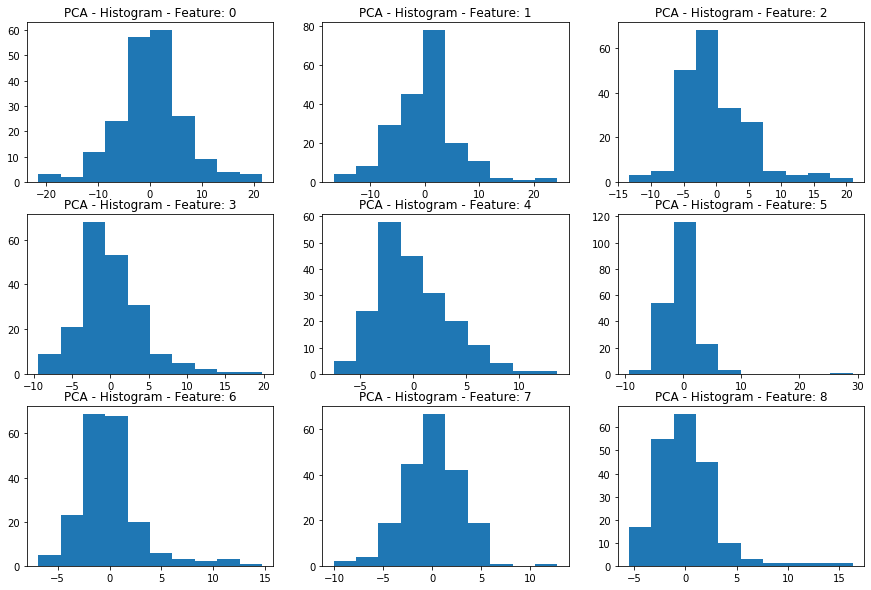

In [15]:
plot_top_features(feature_tot,pca_input, filedir=filedir, taskname=taskname)

# Feature selection
Extract top features above depending on PCA

(200, 312)


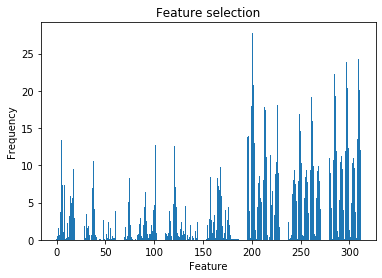

In [16]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, filedir=filedir, taskname=taskname,feature_tot=feature_tot)

## Hyperparameter tuning

In [17]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, input_train_fs, target_train, scoring=scoring, k=k)


Fitting 10 folds for each of 447 candidates, totalling 4470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 1620 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 3020 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3542 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4176 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 4470 out of 4470 | elapsed: 18.1min finished
/usr/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Save model

In [18]:
save_model(grid, filedir=filedir, taskname=taskname)

Save model into: /home/fredrik/Documents/Learning_Systems/Labs/Project/Models/task6.joblib


## Load model

In [19]:
if not grid: 
    grid = load_model(filedir=filedir, taskname=taskname)

## Get Model info

In [20]:
get_model_info(grid)

Best score: 0.8049999999999999
Best params {'clf': MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=400,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False), 'clf__activation': 'relu', 'clf__alpha': 0.1, 'clf__early_stopping': False, 'clf__hidden_layer_sizes': (100, 20), 'clf__max_iter': 400, 'clf__solver': 'lbfgs'}

                                                                                                                                                                                                                                                                    

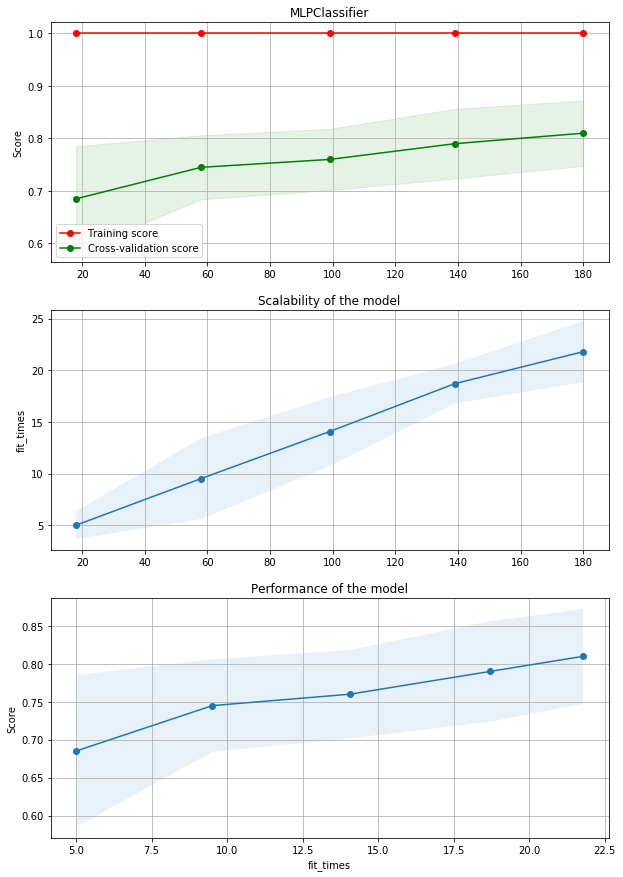

In [21]:
#fig = plot_decision_regions(X=input_train_fs, y=target_train, clf=grid.best_params_['clf'], legend=2)

validate_curve(grid, input_train_fs, target_train,filedir=filedir, taskname=taskname,scoring=scoring, k=k)

/usr/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


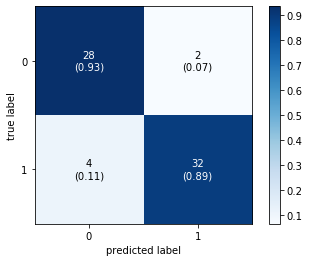

In [22]:
display_confusion_matrix(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname)

# Predict testset

In [23]:
model,predict = predict_model(grid, input_train_fs, target_train, input_test_fs)
print(predict)

[0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1
 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0
 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0]


/usr/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
